In [1]:
import os
import sys
import time
import copy

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
from mpl_toolkits import mplot3d
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import seaborn as sns

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report


from IPython.display import Image

from tqdm.notebook import tqdm

from ptcifar.models import ResNet18

In [2]:
class RandomSphere(Dataset):
    
    """
    Class for generating dataset of a random
    sphere lying in a low dimensional manifold
    embedded in a higher dimensional space
    """
    
    def __init__(self, N=1000, num_neg=None, n=100, k=3, r=10.0,\
                 D=50.0, max_norm=100.0, mu=10, sigma=5, seed=42,\
                 x_ck=None, rotation=None, translation=None):
        
        """
        :param N: total number of samples
        :type N: int
        :param k: low (k-1)-dimensional manifold, embedded in k dims 
        :type k: int
        :param n: dimension of manifold in which sphere is embedded
        :type n: int
        :param r: radius of the sphere
        :type r: float
        :param D: clamping limit for negative examples
        :type D: float
        :return: points
        :param max_norm: maximum possible norm that a point can have
        :type max_norm: float
        :param mu: mean of normal distribution from which we sample
        :type: float
        :param sigma: standard deviation of normal distribution from which we sample
        :type: float
        :param seed: random seed (default is the answer to the ultimate question!)
        :type: int
        """
        
        self.N = N
        self.num_neg = np.floor(self.N / 2).astype(np.int64)
        if num_neg is not None:
            self.num_neg = num_neg
        self.n = n
        self.k = k
        self.r = r
        self.D = D
        self.max_norm = max_norm
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        
        ## setting seed
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        
        self.x_ck = None
        """center of the sphere"""
        if x_ck is not None:
            self.x_ck = x_ck
        
        self.x_cn_trivial_ = None
        """center of the sphere in higher dimension after trivial embedding"""
        
        self.x_cn_tr_ = None
        """center of the sphere in higher dimension after translation"""
        
        self.x_cn_rot_ = None
        """center of the sphere in higher dimension after translation and rotation"""
        
        self.x_cn = None
        """center of sphere in higher dimension"""
        
        self.points_k = None
        """points sampled from the sphere in k-dim"""
        
        self.points_n_trivial_ = None
        """sampled points in higher dimension after trivial embedding"""
        
        self.points_n_tr_ = None
        """sampled points in higher dimension after translation"""
        
        self.points_n_rot_ = None
        """sampled points in higher dimension after translation and rotation"""
        
        self.points_n = None
        """embedding of `self.points_k` in n-dim"""
        
        self.actual_distances = None
        """actual distance of points from the sphere's surface"""
        
        self.distances = None
        """clamped distance of the point from the sphere's surface"""
        
        self.translation = None
        """randomly sampled translation transform"""
        if translation is None:
            self.translation = np.random.normal(self.mu, self.sigma, self.n)
        else:
            self.translation = translation
        
        self.rotation = None
        """randomly sampled rotation transform"""
        if rotation is None:
            self.rotation = np.random.normal(self.mu, self.sigma, (self.n, self.n))
            self.rotation = np.linalg.qr(self.rotation)[0]
        else:
            self.rotation = rotation
        
        
        self.gen_center()
        print("center generated")
        self.gen_points()
        print("points generated")
        self.embed_in_n()
        print("embedding done")
#         self.compute_distances()
        
        self.points_n = torch.from_numpy(self.points_n).float()
        self.points_k = torch.from_numpy(self.points_k).float()
        self.distances = torch.from_numpy(self.distances).float()
        self.actual_distances = torch.from_numpy(self.actual_distances).float()
        
    def __len__(self):
        return self.points_n.shape[0]
    
    def __getitem__(self, idx):
        return self.points_n[idx], self.distances[idx]
        
        
    def gen_center(self):
        """generate a center in lower dimension"""
        if self.x_ck is not None:
            return
        self.x_ck = np.random.normal(self.mu, self.sigma, self.k)
        
    def gen_points(self):
        """generating points in k-dim and embedding in n-dim"""
        points_k = np.random.normal(self.mu, self.sigma, (self.N, self.k))
        points_k = points_k - self.x_ck
        
        norms = np.linalg.norm(points_k, axis=1, ord=2).reshape(-1, 1)
        points_k = (points_k / norms)
        
#         print(np.round(np.linalg.norm(points_k, axis=1, ord=2))[np.ceil(np.linalg.norm(points_k, axis=1, ord=2)) > 1])
        
        assert (np.round(np.linalg.norm(points_k, axis=1, ord=2)) == 1).all()
        
        points_k = self.r * points_k
        
#         neg_norms = np.random.uniform(low=1 + np.finfo(np.float).eps,\
#                                       high=self.max_norm, size=np.floor(self.N / 2).astype(np.int64))
        
#         points_k[:np.floor(self.N / 2).astype(np.int64)] = (neg_norms.reshape(-1, 1) / self.r) * points_k[:np.floor(self.N / 2).astype(np.int64)]
        
        points_k = points_k + self.x_ck
        
        self.points_k = points_k
        
    def make_neg_examples(self):
        """generating negative examples, i.e., points not on the manifold"""
        
        # normal_vectors_to_mfld_at_p are actually centred at x_ck, but 
        # we can imaging the same vector at $p$, and later adjust the coordinates
        # by adding the position vector of $p$ back.
        #
        # Also note that these negative examples are being generated using first
        # half of self.points_k
        normal_vectors_to_mfld_at_p = self.points_k[:self.num_neg] - self.x_ck
        embedded_normal_vectors_to_mfld_at_p = np.zeros((self.num_neg, self.n))
        embedded_normal_vectors_to_mfld_at_p[:, :self.k] = normal_vectors_to_mfld_at_p
        
        neg_examples = np.zeros((self.num_neg, self.n))
        neg_distances = np.zeros(self.num_neg)
        
        # canonical basis $e_i$ over leftover dimensions
        remaining_dims = self.n - self.k
        leftover_basis = np.eye(remaining_dims)
        
        # variable to store spanning set
        span_set = np.zeros((remaining_dims + 1, self.n))
        span_set[1:, self.k:] = leftover_basis
        
        
        for i in tqdm(range(self.num_neg)):

            n_cap = embedded_normal_vectors_to_mfld_at_p[i]
            
            # span set is n_cap and leftover basis
            span_set[0] = n_cap
            

            # sample random coefficients
#             coefficients = np.random.uniform(1 + np.finfo(np.float).eps, self.max_norm, span_set.shape[0])
            coefficients = np.random.normal(self.mu, self.sigma, span_set.shape[0])

            # take linear combination
            neg_examples[i] = np.sum(coefficients.reshape(-1, 1) * span_set, axis=0)
            
        # re-scale with random norms, sampled from U[\epsilon, self.r/2]
#         neg_norms = np.random.uniform(low=0, high=0, size=self.num_neg)
        neg_norms = np.random.uniform(low=1e-6 + np.finfo(np.float).eps, high=self.r / 2, size=self.num_neg)
#         neg_norms = np.random.normal(self.mu, self.sigma, size=self.num_neg)
        neg_examples = (neg_norms.reshape(-1, 1) / np.linalg.norm(neg_examples, axis=1, ord=2).reshape(-1, 1)) * neg_examples

        # add position vector of $p$ to get origin centered coordinates
        neg_examples[:, :self.k] = neg_examples[:, :self.k] + self.points_k[:self.num_neg]

        # distances from the manifold will be the norms the samples were rescaled by
        neg_distances = neg_norms
        
        return neg_examples, neg_distances
            
    
    
    def embed_in_n(self):
        """embedding center and sampled points in `self.n`-dims"""
        
        # embedding the center
        self.x_cn_trivial_ = np.zeros(self.n)
        self.x_cn_trivial_[:self.k] = self.x_ck
        self.x_cn_tr_ = self.x_cn_trivial_ + self.translation
        self.x_cn_rot_ = np.dot(self.rotation, self.x_cn_tr_)
        self.x_cn = self.x_cn_rot_
        
        
        # generate the negative examples
        neg_examples, neg_distances = self.make_neg_examples()
        
        #embedding the points
        self.points_n_trivial_ = np.zeros((self.N, self.n))
        self.points_n_trivial_[:self.num_neg] = neg_examples
        
        self.points_n_trivial_[self.num_neg:, :self.k] = self.points_k[self.num_neg:]
        self.points_n_tr_ = self.points_n_trivial_ + self.translation
        
        self.points_n_rot_ = np.dot(self.rotation, self.points_n_tr_.T).T
        
        self.points_n = self.points_n_rot_
        
        self.actual_distances = np.zeros((self.N, 1))
        self.actual_distances[:self.num_neg] = neg_distances.reshape(-1, 1)
        self.actual_distances[self.num_neg:] = np.linalg.norm(self.points_n[self.num_neg:] - self.x_cn, axis=1, ord=2).reshape(-1, 1) - self.r
        self.distances = np.clip(self.actual_distances, a_min=0, a_max=self.D)
        
        # checking that the on-manifold points are still self.r away from center
        print(np.round(np.linalg.norm(self.points_n[self.num_neg:] - self.x_cn, axis=1, ord=2)))
        assert (np.round(np.linalg.norm(self.points_n[self.num_neg:] - self.x_cn, axis=1, ord=2)) == self.r).all()
    
    
    def viz_test(self, dimX=0, dimY=1, dimZ=2, num_pre_img=5):
        """
            generate plots that act as visual sanity checks
            
            1. distribution of distance labels from manifold
            2. distribution of actual distances from manifold
            3. on-manifold samples - trivial, translated and rotated in input 3 dims
            4. off-manifold samples - pick one, find its coresponding index in self.points_k,
               transform it to the on-manifold sample, assert that the distance between the two is equal
               to the distance label and plot this distance
        """
        
        plt.hist(self.distances.numpy())
        plt.xlabel("clipped (D={d}) distances from manifold".format(d=self.D))
        plt.ylabel("frequency")
        plt.title("distribution of label distances from the manifold")
        plt.show()
        
        plt.hist(self.actual_distances.numpy())
        plt.xlabel("actual distances from manifold")
        plt.ylabel("frequency")
        plt.title("distribution of actual distances from the manifold")
        plt.show()
        
        # plot the on-manifold examples
        
        # before translation
        fig = plt.figure(figsize = (10, 7))
        ax1 = plt.axes(projection ="3d")
        
        ax1.scatter3D(self.points_n_trivial_[self.num_neg:, dimX],\
                      self.points_n_trivial_[self.num_neg:, dimY], self.points_n_trivial_[self.num_neg:, dimZ])
        
        plt.title("on-manifold samples (trivial embedding)")
        plt.show()
        
        # before rotation
        fig = plt.figure(figsize = (10, 7))
        ax1 = plt.axes(projection ="3d")
        
        ax1.scatter3D(self.points_n_tr_[self.num_neg:, dimX],\
                      self.points_n_tr_[self.num_neg:, dimY], self.points_n_tr_[self.num_neg:, dimZ])
        
        plt.title("on-manifold samples (after translation)")
        plt.show()
        
        # after rotation
        fig = plt.figure(figsize = (10, 7))
        ax1 = plt.axes(projection ="3d")
        
        ax1.scatter3D(self.points_n[self.num_neg:, dimX],\
                      self.points_n[self.num_neg:, dimY], self.points_n[self.num_neg:, dimZ])
        
        plt.title("on-manifold samples (after rotation)")
        plt.show()
        
        
        # plots for off-manifold samples
        
        #indices to show for pre-images
        idx = np.random.choice(np.arange(self.num_neg), num_pre_img)
        
        # trivial pre_image
        
        neg_pre_img = self.points_k[:self.num_neg]
        neg_pre_img_trivial_ = np.zeros((self.num_neg, self.n))
        neg_pre_img_trivial_[:, :self.k] = neg_pre_img
        
        fig = plt.figure(figsize = (10, 7))
        ax1 = plt.axes(projection ="3d")
        
        ax1.scatter3D(self.points_n_trivial_[self.num_neg:, dimX],\
              self.points_n_trivial_[self.num_neg:, dimY],\
              self.points_n_trivial_[self.num_neg:, dimZ], color="blue", label="on-manifold", s=1, marker="1")
        
        
        
        ax1.scatter3D(neg_pre_img_trivial_[:, dimX][idx],\
                      neg_pre_img_trivial_[:, dimY][idx],\
                      neg_pre_img_trivial_[:, dimZ][idx], color="green", marker="^", label="trivial pre-image", s=80)
        
        
        
        ax1.scatter3D(self.points_n_trivial_[:self.num_neg, dimX][idx],\
                      self.points_n_trivial_[:self.num_neg, dimY][idx],\
                      self.points_n_trivial_[:self.num_neg, dimZ][idx], color="red", label="off-manifold")
        
        actual_distances_trivial_ = np.linalg.norm(neg_pre_img_trivial_\
                               - self.points_n_trivial_[:self.num_neg], ord=2, axis=1)
        
        for i in idx:
            ax1.plot([neg_pre_img_trivial_[:, dimX][i], self.points_n_trivial_[:self.num_neg, dimX][i]],\
                    [neg_pre_img_trivial_[:, dimY][i], self.points_n_trivial_[:self.num_neg, dimY][i]],\
                    [neg_pre_img_trivial_[:, dimZ][i], self.points_n_trivial_[:self.num_neg, dimZ][i]], color="black")
            ax1.text(np.mean([neg_pre_img_trivial_[:, dimX][i], self.points_n_trivial_[:self.num_neg, dimX][i]]),\
                    np.mean([neg_pre_img_trivial_[:, dimY][i], self.points_n_trivial_[:self.num_neg, dimY][i]]),\
                    np.mean([neg_pre_img_trivial_[:, dimZ][i], self.points_n_trivial_[:self.num_neg, dimZ][i]]),\
                    "{:.2f}".format(actual_distances_trivial_[i].item()))
        
        
        plt.legend()
        plt.title("pre-image samples (trivial embedding)")
        plt.show()
        
        plt.hist(np.linalg.norm(neg_pre_img_trivial_\
                               - self.points_n_trivial_[:self.num_neg], ord=2, axis=1) - self.actual_distances[:self.num_neg].numpy().reshape(-1))
        plt.ylabel("freq")
        plt.xlabel("error value")
        plt.title("error distribution for distance value from manifold (trivial)")
        plt.show()
        
        
        # translated pre_image
        
        
        neg_pre_img_tr_ = neg_pre_img_trivial_ + self.translation
        
        fig = plt.figure(figsize = (10, 7))
        ax1 = plt.axes(projection ="3d")
        
        ax1.scatter3D(self.points_n_tr_[self.num_neg:, dimX],\
              self.points_n_tr_[self.num_neg:, dimY],\
              self.points_n_tr_[self.num_neg:, dimZ], color="blue", label="on-manifold", s=1, marker="1")
        
        
        ax1.scatter3D(neg_pre_img_tr_[:, dimX][idx],\
                      neg_pre_img_tr_[:, dimY][idx],\
                      neg_pre_img_tr_[:, dimZ][idx], color="green", marker="^", label="translated pre-image", s=80)
        
        
        
        ax1.scatter3D(self.points_n_tr_[:self.num_neg, dimX][idx],\
                      self.points_n_tr_[:self.num_neg, dimY][idx],\
                      self.points_n_tr_[:self.num_neg, dimZ][idx], color="red", label="off-manifold")
        
        for i in idx:
            ax1.plot([neg_pre_img_tr_[:, dimX][i], self.points_n_tr_[:self.num_neg, dimX][i]],\
                    [neg_pre_img_tr_[:, dimY][i], self.points_n_tr_[:self.num_neg, dimY][i]],\
                    [neg_pre_img_tr_[:, dimZ][i], self.points_n_tr_[:self.num_neg, dimZ][i]], color="black")
            ax1.text(np.mean([neg_pre_img_tr_[:, dimX][i], self.points_n_tr_[:self.num_neg, dimX][i]]),\
                    np.mean([neg_pre_img_tr_[:, dimY][i], self.points_n_tr_[:self.num_neg, dimY][i]]),\
                    np.mean([neg_pre_img_tr_[:, dimZ][i], self.points_n_tr_[:self.num_neg, dimZ][i]]),\
                    "{:.2f}".format(self.actual_distances[i].item()))
        
        
        plt.legend()
        plt.title("pre-image samples (translated embedding)")
        plt.show()
        
        plt.hist(np.linalg.norm(neg_pre_img_tr_\
                               - self.points_n_tr_[:self.num_neg], ord=2, axis=1) - self.actual_distances[:self.num_neg].numpy().reshape(-1))
        plt.ylabel("freq")
        plt.xlabel("error value")
        plt.title("error distribution for distance value from manifold (tanslated)")
        plt.show()
        
        
        # rotated pre_image
        
        
        neg_pre_img_rot_ = np.dot(self.rotation, neg_pre_img_tr_.T).T
        
        fig = plt.figure(figsize = (10, 7))
        ax1 = plt.axes(projection ="3d")
        
        ax1.scatter3D(self.points_n_rot_[self.num_neg:, dimX],\
              self.points_n_rot_[self.num_neg:, dimY],\
              self.points_n_rot_[self.num_neg:, dimZ], color="blue", label="on-manifold", s=1, marker="1")
        
        
        ax1.scatter3D(neg_pre_img_rot_[:, dimX][idx],\
                      neg_pre_img_rot_[:, dimY][idx],\
                      neg_pre_img_rot_[:, dimZ][idx], color="green", marker="^", label="rotated pre-image", s=80)
        
        
        
        ax1.scatter3D(self.points_n_rot_[:self.num_neg, dimX][idx],\
                      self.points_n_rot_[:self.num_neg, dimY][idx],\
                      self.points_n_rot_[:self.num_neg, dimZ][idx], color="red", label="off-manifold")
        
        for i in idx:
            ax1.plot([neg_pre_img_rot_[:, dimX][i], self.points_n_rot_[:self.num_neg, dimX][i]],\
                    [neg_pre_img_rot_[:, dimY][i], self.points_n_rot_[:self.num_neg, dimY][i]],\
                    [neg_pre_img_rot_[:, dimZ][i], self.points_n_rot_[:self.num_neg, dimZ][i]], color="black")
            ax1.text(np.mean([neg_pre_img_rot_[:, dimX][i], self.points_n_rot_[:self.num_neg, dimX][i]]),\
                    np.mean([neg_pre_img_rot_[:, dimY][i], self.points_n_rot_[:self.num_neg, dimY][i]]),\
                    np.mean([neg_pre_img_rot_[:, dimZ][i], self.points_n_rot_[:self.num_neg, dimZ][i]]),\
                    "{:.2f}".format(self.actual_distances[i].item()))
        
        
        plt.legend()
        plt.title("pre-image samples (rotated embedding)")
        plt.show()
        
        plt.hist(np.linalg.norm(neg_pre_img_rot_\
                               - self.points_n_rot_[:self.num_neg], ord=2, axis=1) - self.actual_distances[:self.num_neg].numpy().reshape(-1))
        plt.ylabel("freq")
        plt.xlabel("error value")
        plt.title("error distribution for distance value from manifold (rotated)")
        plt.show()
        
        min_dist_vals = list()
        
        for i in idx:
            
            neg_ex = self.points_n[i]
            min_dist = None
            
            for j in range(self.num_neg):
                
                a_pre_img = neg_pre_img_rot_[j]
#                 print(neg_ex.shape, a_pre_img.shape)
                dist = np.linalg.norm(neg_ex - a_pre_img, ord=2)
                
                if min_dist is None or dist < min_dist:
                    min_dist = dist
                    
            min_dist_vals.append(min_dist)
            
        errors = np.abs(self.actual_distances[idx].numpy().reshape(-1) - np.array(min_dist_vals))
        rel_errors = errors / self.actual_distances[idx].numpy().reshape(-1)
        print("absolute errors:", errors)
        print("relative errors:", rel_errors)
        

In [3]:
dummy_params = {
    "N": 100000,
    "num_neg": None,
    "n": 3,
    "k": 2,
    "r": 100.0,
    "D": 25.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 85
}

dummy_set = RandomSphere(**dummy_params)



center generated
points generated



[100. 100. 100. ... 100. 100. 100.]
embedding done


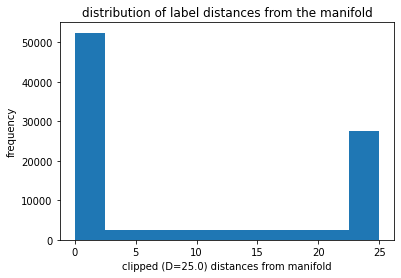

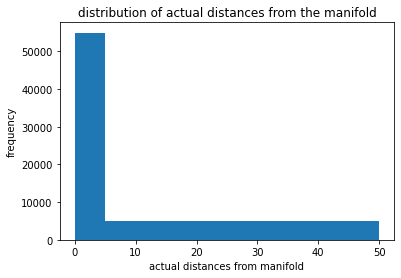

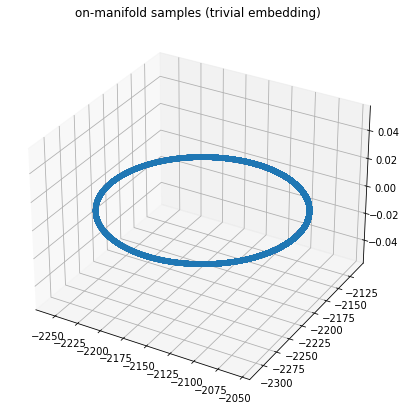

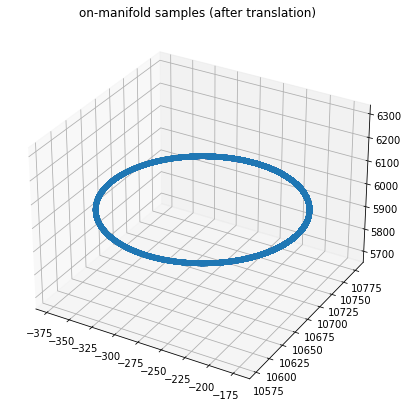

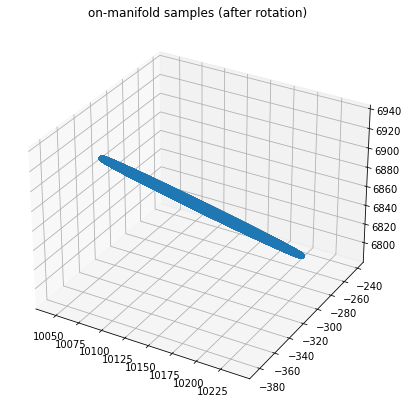

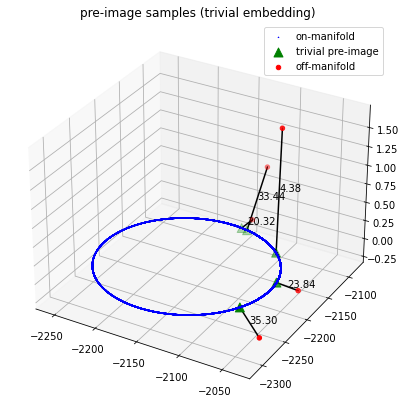

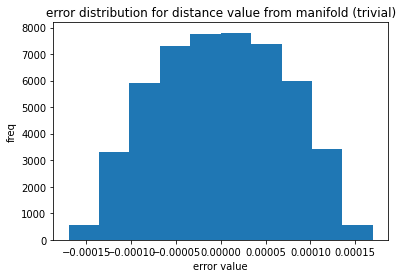

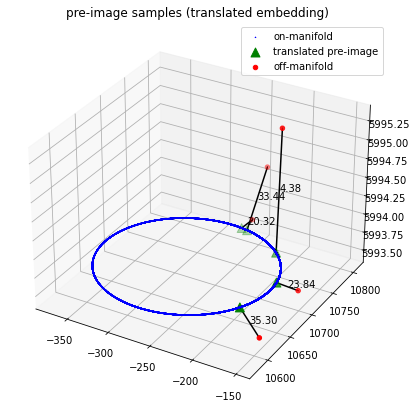

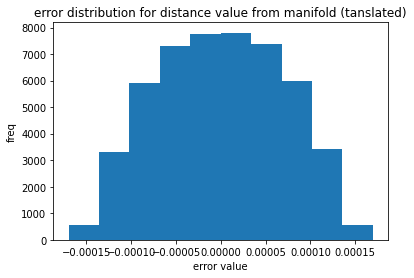

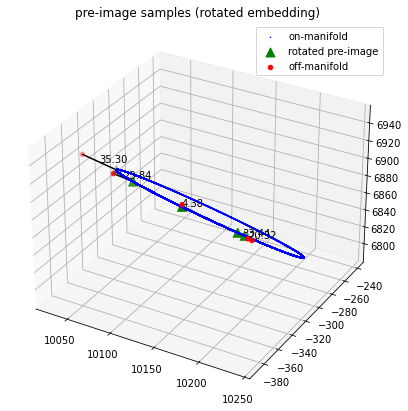

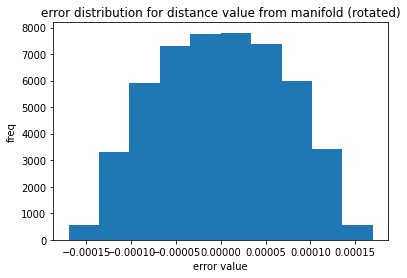

absolute errors: [0.00016208 0.00023663 0.00018345 0.00019109 0.00017176]
relative errors: [6.79921545e-06 7.07588841e-06 9.02872718e-06 5.41330750e-06
 3.92318523e-05]


In [4]:
dummy_set.viz_test()

In [3]:
class MLP(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_sizes=[512, 512, 512, 512]):
        
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        
        layers = [("fcn-0", nn.Linear(self.input_size, hidden_sizes[0])), ("relu-0", nn.ReLU())]
        
        for i in range(len(hidden_sizes) - 1):

            layers.append(("fcn-{n}".format(n=i+1), nn.Linear(hidden_sizes[i], hidden_sizes[i+1])))
            layers.append(("relu-{n}".format(n=i+1), nn.ReLU()))
                    
        layers.append(("fcn-" + str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], output_size)))
        
        self.layers = nn.Sequential(OrderedDict(layers))
        
    def forward(self, X):
        logits = self.layers(X)
        return logits

In [4]:
class ConvNet1(nn.Module):
    """CNN-based architecture"""
    
    
    def __init__(self, input_size, output_size):
        
        super(ConvNet1, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2)
        self.bn_1 = nn.BatchNorm1d(16)
        self.conv_2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.bn_2 = nn.BatchNorm1d(16)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)
        self.dp_1 = nn.Dropout(0.2)
        
        
        
        
        self.blk_out = nn.Sequential(OrderedDict([
            ("fc-1", nn.Linear(in_features=16 * 124, out_features=1))
        ]))
        
    def forward(self, X):
#         print(X.shape)
        X = X.view(X.shape[0], 1, -1)
#         print(X.shape)

        logits = self.conv_1(X)
        logits = self.bn_1(logits)
        logits = self.conv_2(logits)
        logits = self.bn_2(logits)
        logits = self.maxpool_1(logits)
        logits = self.dp_1(logits)
#         print(logits.shape)
        logits = logits.view(logits.shape[0], -1)
        logits = self.blk_out(logits)
        
        return logits

In [5]:
class ConvNet2(nn.Module):
    """CNN-based architecture"""
    
    
    def __init__(self, input_size, output_size):
        
        super(ConvNet2, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv_11 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=2)
        self.bn_11 = nn.BatchNorm1d(32)
        self.conv_12 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        self.bn_12 = nn.BatchNorm1d(32)
        self.maxpool_11 = nn.MaxPool1d(kernel_size=2)
        self.dp_11 = nn.Dropout(0.2)
        
        self.conv_21 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
        self.bn_21 = nn.BatchNorm1d(16)
        self.conv_22 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.bn_22 = nn.BatchNorm1d(16)
        self.maxpool_21 = nn.MaxPool1d(kernel_size=2)
        self.dp_21 = nn.Dropout(0.5)
        
        
        
        
        self.blk_out = nn.Sequential(OrderedDict([
            ("fc-1", nn.Linear(in_features=16 * 15, out_features=128)),
            ("relu-fc-1", nn.ReLU()),
            ("bn-fc-1", nn.BatchNorm1d(128)),
            ("dp-fc-1", nn.Dropout(0.8)),
            ("fc-2", nn.Linear(in_features=128, out_features=1))
        ]))
        
    def forward(self, X):
#         print(X.shape)
        X = X.view(X.shape[0], 1, -1)
#         print(X.shape)

        logits = F.relu(self.conv_11(X))
        logits = self.bn_11(logits)
        logits = F.relu(self.conv_12(logits))
        logits = self.bn_12(logits)
        logits = self.maxpool_11(logits)
#         logits = self.dp_11(logits)
        
        logits = F.relu(self.conv_21(logits))
        logits = self.bn_21(logits)
        logits = F.relu(self.conv_22(logits))
        logits = self.bn_22(logits)
        logits = self.maxpool_21(logits)
#         logits = self.dp_21(logits)
        
#         print(logits.shape)
        logits = logits.view(logits.shape[0], -1)
        logits = self.blk_out(logits)
        
        return logits

In [6]:
class ConvNet3(nn.Module):
    """CNN-based architecture"""
    
    
    def __init__(self, input_size, output_size):
        
        super(ConvNet3, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv_11 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2)
        self.bn_11 = nn.BatchNorm1d(16)
        self.conv_12 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.bn_12 = nn.BatchNorm1d(16)
        self.maxpool_11 = nn.MaxPool1d(kernel_size=2)
        self.dp_11 = nn.Dropout(0.2)
        
        self.conv_21 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.bn_21 = nn.BatchNorm1d(32)
        self.conv_22 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        self.bn_22 = nn.BatchNorm1d(32)
        self.maxpool_21 = nn.MaxPool1d(kernel_size=2)
        self.dp_21 = nn.Dropout(0.5)
        
        
        
        
        self.blk_out = nn.Sequential(OrderedDict([
            ("fc-1", nn.Linear(in_features=32 * 15, out_features=128)),
            ("relu-fc-1", nn.ReLU()),
            ("bn-fc-1", nn.BatchNorm1d(128)),
            ("dp-fc-1", nn.Dropout(0.8)),
            ("fc-2", nn.Linear(in_features=128, out_features=1))
        ]))
        
    def forward(self, X):
#         print(X.shape)
        X = X.view(X.shape[0], 1, -1)
#         print(X.shape)

        logits = F.relu(self.conv_11(X))
        logits = self.bn_11(logits)
        logits = F.relu(self.conv_12(logits))
        logits = self.bn_12(logits)
        logits = self.maxpool_11(logits)
        logits = self.dp_11(logits)
        
        logits = F.relu(self.conv_21(logits))
        logits = self.bn_21(logits)
        logits = F.relu(self.conv_22(logits))
        logits = self.bn_22(logits)
        logits = self.maxpool_21(logits)
        logits = self.dp_21(logits)
        
#         print(logits.shape)
        logits = logits.view(logits.shape[0], -1)
        logits = self.blk_out(logits)
        
        return logits

In [30]:
def train(model, optimizer, loss_func, dataloaders, device,\
          num_epochs, save_dir, scheduler, task="regression", name="MLP_512x4_in1000",\
          scheduler_params={"warmup": 10, "cooldown": 300}):
    """
        Function to train the model. Also dumps the best model.
        
        Returns the best model and optimizers

    """
    
    # storing the start_lr
    start_lr = optimizer.param_groups[0]['lr']
    
    TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

    
    model_dir = os.path.join(save_dir, TIME_STAMP, "models")
    plot_dir = os.path.join(save_dir, TIME_STAMP, "plots")
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)
    
    plot_fn = os.path.join(plot_dir, name + "_" + TIME_STAMP)
    
    liveloss = PlotLosses(fig_path=plot_fn)
    
    phase = "train"
    
    last_best_epoch_loss = None
    
    
    
    for epoch in tqdm(range(num_epochs)):
        
        
        
        logs = {
            "loss": 0,
            "val_loss": 0,
            "lr": start_lr
        }
        
        
        
        for phase in ["train", "val"]:
            
            dl = dataloaders[phase]
            
            pred_classes = None
            target_classes = None
            
            if task == "clf":
                pred_classes = torch.zeros(dl.dataset.N)
                target_classes = torch.zeros(dl.dataset.N)
            
            if phase == "train":
                torch.set_grad_enabled(True)
                model.train()
            else:
                torch.set_grad_enabled(False)
                model.eval()
            
            num_batches = 0
            
            prefix = ""
            if phase == "val":
                prefix = "val_"
            
            for (i, batch) in enumerate(dataloaders[phase]):
                
                points = batch[0].to(device)
                distances = batch[1].to(device)
                
                model.zero_grad()
                model = model.to(device)
                
                logits = model(points)
                loss = loss_func(logits, distances)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
                    
                logs[prefix + "loss"] += loss.detach().cpu().item()
                
                num_batches = i + 1
                
                points = points.cpu()
                distances = distances.cpu()
                model = model.cpu()
                logits = logits.cpu()
                
                if task == "clf":
                    pred_classes[i*points.shape[0]:(i+1)*points.shape[0]] = torch.max(logits, axis=1)[1]
                    target_classes[i*points.shape[0]:(i+1)*points.shape[0]] = distances
            
            if task == "clf":
                f1 = f1_score(target_classes, pred_classes)
                acc = accuracy_score(target_classes, pred_classes)

                logs[prefix + "f1"] = f1
                logs[prefix + "acc"] = acc
                    
            
            # dividing by the number of batches
            logs[prefix + "loss"] /= num_batches
        
        check = last_best_epoch_loss is None or logs["val_loss"] < last_best_epoch_loss
        stat = "val_loss"
        if task == "clf":
            check = last_best_epoch_loss is None or logs["val_f1"] > last_best_epoch_loss
            stat = "val_f1"
            
        if check:
            last_best_epoch_loss = logs[stat]
            dump = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': logs['val_loss'],
                'loss': logs["loss"],
                'scheduler_params': scheduler_params,
                'scheduler_state_dict': scheduler.state_dict()
            }
            
            if task == "clf":
                dump["acc"] = logs["acc"]
                dump["val_acc"] = logs["val_acc"]
                dump["f1"] = logs["f1"]
                dump["val_f1"] = logs["val_f1"]
                
            torch.save(dump, os.path.join(model_dir, NAME + "_"+ TIME_STAMP + "val_loss_" + str(logs["val_loss"]) + ".pth"))
        
#         if scheduler is not None:
            
#             if epoch > scheduler["start_iter"]:
#                 for param_group in optimizer.param_groups:
#                     param_group['lr'] = max(0, start_lr + (((start_lr - 0) / (scheduler["start_iter"] - scheduler["end_iter"])) * (epoch - scheduler["start_iter"])))
#                     logs["lr"] = param_group["lr"]
        
        logs["lr"] = optimizer.param_groups[0]["lr"]
        liveloss.update(logs)
        liveloss.draw()
        
        scheduler.step()
        
    return model, optimizer
            
            


In [8]:
def test(model, dataloader, device, task="regression"):
    
    model.eval()
    
    all_logits = None
    all_distances = None
    
    with torch.no_grad():
        
        for batch in tqdm(dataloader):
            
            points = batch[0].to(device)
            distances = batch[1]
            
            model.zero_grad()
            model = model.to(device)

            logits = model(points).detach().cpu()

            points = points.cpu()
            distances = distances.cpu()
            model = model.cpu()
            
            if all_logits is None:
                all_logits = logits
            else:
                all_logits = torch.cat((all_logits, logits))
            
            if all_distances is None:
                all_distances = distances
            else:
                all_distances = torch.cat((all_distances, distances))
            
    if task == "regression":
        mse = mean_squared_error(all_distances, all_logits)
        mse_on_mfld = mean_squared_error(all_distances[np.round(all_distances) == 0], all_logits[np.round(all_distances) == 0])



        print("MSE for the learned distances:", mse)
        print("MSE for the learned distances (on-manifold):", mse_on_mfld)
        return mse, mse_on_mfld, all_distances, all_logits
    
    elif task == "clf":
        y_pred = torch.max(all_logits, axis=1)[1]
        print(classification_report(all_distances.reshape(-1), y_pred))
        acc = accuracy_score(all_distances.reshape(-1), y_pred)
        f1 = f1_score(all_distances.reshape(-1), y_pred)
        
        return acc, f1
    
    # TODO: fix this for concentric dataset
    
            

In [ ]:
n = 32 * 32 * 3

train_params = {
    "N": 50000,
    "num_neg": None,
    "n": n,
    "k": 2,
    "r": 100.0,
    "D": 25.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 23
}

# train_set = RandomSphere(**train_params)

val_params = {
    "N": 10000,
    "num_neg": None,
    "n": n,
    "k": 2,
    "r": 100.0,
    "D": 25.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 101,
    "x_ck": train_set.x_ck,
    "translation": train_set.translation,
    "rotation": train_set.rotation
}

test_params = {
    "N": 10000,
    "num_neg": None,
    "n": n,
    "k": 2,
    "r": 100.0,
    "D": 25.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 89,
    "x_ck": train_set.x_ck,
    "translation": train_set.translation,
    "rotation": train_set.rotation
}

# val_set = RandomSphere(**val_params)
# test_set = RandomSphere(**test_params)


In [9]:
# torch.save(train_set, "../datasets/expB/train_cifar_dim.pt")
# torch.save(val_set, "../datasets/expB/val_cifar_dim.pt")
# torch.save(test_set, "../datasets/expB/test_cifar_dim.pt")

In [10]:
train_set = torch.load("../datasets/expB/train_cifar_dim.pt")
val_set = torch.load("../datasets/expB/val_cifar_dim.pt")
test_set = torch.load("../datasets/expB/test_cifar_dim.pt")

In [11]:
# for sanity checks
# train_set.distances = torch.zeros_like(train_set.distances)
# val_set.distances = torch.zeros_like(val_set.distances)

# train_set.distances = train_set.points_n[:, 0].reshape(-1, 1)
# val_set.distances = val_set.points_n[:, 0].reshape(-1, 1)


# for classification task
# train_set.distances = torch.zeros_like(train_set.distances).reshape(-1)
# train_set.distances[:train_set.num_neg] = 1
# train_set.distances = train_set.distances.long()

# val_set.distances = torch.zeros_like(val_set.distances).reshape(-1)
# val_set.distances[:val_set.num_neg] = 1
# val_set.distances = val_set.distances.long()

# test_set.distances = torch.zeros_like(test_set.distances).reshape(-1)
# test_set.distances[:test_set.num_neg] = 1
# test_set.distances = test_set.distances.long()

In [34]:
BATCH_SIZE = 512
NUM_WORKERS = 8

dataloaders = {
    "train": DataLoader(dataset=train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "val": DataLoader(dataset=val_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "test": DataLoader(dataset=test_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
}

In [35]:
assert (train_set.x_cn == val_set.x_cn).all()

In [36]:
# model = MLP(input_size=3, output_size=1, hidden_sizes=[2048, 1024, 512])
model = ResNet18(num_classes=1)
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5)

optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

NUM_EPOCHS = 150
scheduler_params = {"warmup": 10, "cooldown": 50}
lr_sched_factor = lambda epoch: epoch / (scheduler_params["warmup"]) if epoch <= scheduler_params["warmup"] else (1 if epoch > scheduler_params["warmup"] and epoch < scheduler_params["cooldown"] else max(0, 1 + (1 / (scheduler_params["cooldown"] - NUM_EPOCHS)) * (epoch - scheduler_params["cooldown"])))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NAME = "CIFAR_ResNet18_1e_2_sgd_warmup"
SAVE_DIR = os.path.join("../dumps/expB_learning_distance_from_mfld", NAME)

In [37]:
optimizer.param_groups[0]["lr"]

0.0

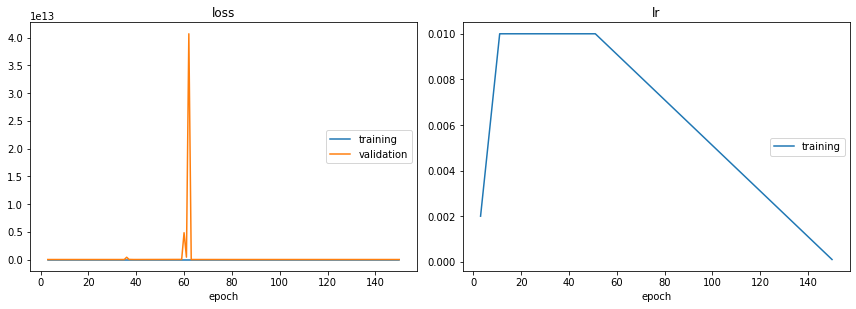

loss:
training   (min:  115.637, max:  250.213, cur:  120.140)
validation (min:  119.988, max: 40680208675635.203, cur:  120.272)

lr:
training   (min:    0.000, max:    0.010, cur:    0.000)



In [38]:
model, optimizer = train(model=model, optimizer=optimizer, loss_func=loss_func, dataloaders=dataloaders,\
                         device=device, task="regression",num_epochs=NUM_EPOCHS, save_dir=SAVE_DIR,\
                         name=NAME, scheduler=scheduler, scheduler_params=scheduler_params)



In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
pytorch_total_params

In [39]:
best_dump_fn = "/data/adv_geom/dumps/expB_learning_distance_from_mfld/CIFAR_ResNet18_1e_2_sgd_warmup/12042021-083806/models/CIFAR_ResNet18_1e_2_sgd_warmup_12042021-083806val_loss_119.98835372924805.pth"

best_dump = torch.load(best_dump_fn)

best_model = ResNet18(num_classes=1)

best_model.load_state_dict(best_dump["model_state_dict"])

best_dump["epoch"], best_dump["loss"], best_dump["val_loss"]

(89, 120.20035514053033, 119.98835372924805)

In [40]:
type(best_model)

ptcifar.models.resnet.ResNet

In [41]:
mse, mse_on_mfld, all_distances, all_logits = test(model, dataloaders["test"], device)
# acc, f1 = test(model, dataloaders["test"], device, task="clf")





MSE for the learned distances: 120.3814
MSE for the learned distances (on-manifold): 87.46198


In [ ]:
acc, f1

In [ ]:

distances_on_mfld = all_distances.reshape(-1)[np.round(all_distances.reshape(-1), decimals=10) == 0]
logits_on_mfld = all_logits.reshape(-1)[np.round(all_distances.reshape(-1), decimals=10) == 0]

errors_on_mfld = torch.sqrt((distances_on_mfld - logits_on_mfld) ** 2)

distances_off_mfld = all_distances.reshape(-1)[np.round(all_distances.reshape(-1), decimals=10) != 0]
logits_off_mfld = all_logits.reshape(-1)[np.round(all_distances.reshape(-1), decimals=10) != 0]

errors_off_mfld = torch.sqrt((distances_off_mfld - logits_off_mfld) ** 2)


In [ ]:
plt.hist([errors_on_mfld.numpy(), errors_off_mfld.numpy()], label=["on-manifold", "off-manifold"])
# plt.hist(, label="off-manifold")
plt.legend()
plt.xlabel("mse value")
plt.ylabel("freq")

plt.title("error dist. for 2-dim mfld. embedded in 1000 dim space")
plt.show()

In [ ]:
plt.scatter(distances_on_mfld, errors_on_mfld, label="on-manifold")
plt.scatter(distances_off_mfld, errors_off_mfld, label="off-manifold")
plt.legend()
plt.xlim(-5, 50)
plt.xlabel("distance label")
plt.ylabel("mse")
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

y = train_set.distances.numpy().reshape(-1)
X = train_set.points_n.numpy()
regr = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.1))
regr.fit(X, y)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = regr.predict(train_sedt.points_n.numpy())
y_true = train_set.distances.numpy().reshape(-1)
mean_squared_error(y_true, y_pred)

# Trying to learn distance from multiple spheres

## Concentric Spheres

In [ ]:
class ConcentricSpheres(Dataset):
    
    """
    Class for generating dataset of concentric random
    spheres lying in a low dimensional manifold
    embedded in a higher dimensional space
    
    Note: no explicit -ve examples. Points on one sphere are
    negative examples for the other
    """
    
    def __init__(self, num_spheres=2, N=[1000, 1000],
                 n=100, k=3, r=[10.0, 20.0], D=[50.0, 55.0],
                 mu=10, sigma=5, seed=42):
        
        """
        :param num_spheres: total number of spheres
        :type num_spheres: int
        :param N: total number of samples per sphere
        :type N: list[int]
        :param k: low (k)-dimensional manifold 
        :type k: int
        :param n: dimension of manifold in which sphere is embedded
        :type n: int
        :param r: radii of the spheres
        :type r: list[float]
        :param D: list of clamping limits for negative examples
        :type D: list[float]
        :return: points
        :param mu: mean of normal distribution from which we sample
        :type: float
        :param sigma: standard deviation of normal distribution from which we sample
        :type: float
        :param seed: random seed (default is the answer to the ultimate question!)
        :type: int
        """
        
        self.num_spheres = num_spheres
        self.N = N
        self.n = n
        self.k = k
        self.r = r
        self.D = D
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        
        ## setting seed
        torch.manual_seed(42)
        np.random.seed(42)
        
        self.x_ck = None
        """center of the sphere"""
        
        self.x_cn = None
        """center of sphere in higher dimension"""
        
        self.points_k = None
        """points sampled from the sphere in k-dim"""
        
        self.points_n = None
        """embedding of `self.points_k` in n-dim"""
        
        self.actual_distances = None
        """actual distance of points from the sphere's surface"""
        
        self.distances = None
        """clamped distance of the point from the sphere's surface"""
        
        
        self.translation = np.random.normal(self.mu, self.sigma, self.n)
        """randomly sampled translation transform"""
        
        
        self.gen_center()
        self.gen_points()
        self.embed_in_n()
        self.compute_distances()
        
        self.points_n = torch.from_numpy(self.points_n).float()
        self.points_k = torch.from_numpy(self.points_k).float()
        self.distances = torch.from_numpy(self.distances).float()
        self.actual_distances = torch.from_numpy(self.actual_distances).float()
        
    def __len__(self):
        return self.points_n.shape[0]
    
    def __getitem__(self, idx):
        return self.points_n[idx], self.distances[idx]
        
        
    def gen_center(self):
        """generate a center for both spheres in lower dimension"""
        self.x_ck = np.random.normal(self.mu, self.sigma, self.k)
        
    def gen_points(self):
        """generating points in k-dim and embedding in n-dim"""
        
        for i in range(self.num_spheres):
            
            points_k = np.random.normal(self.mu, self.sigma, (self.N[i], self.k))
            points_k = points_k - self.x_ck

            norms = np.linalg.norm(points_k, axis=1, ord=2).reshape(-1, 1)
            points_k = (points_k / norms)

    #         print(np.round(np.linalg.norm(points_k, axis=1, ord=2))[np.ceil(np.linalg.norm(points_k, axis=1, ord=2)) > 1])

            assert (np.round(np.linalg.norm(points_k, axis=1, ord=2)) == 1).all()

            points_k = self.r[i] * points_k


            if self.points_k is None:
                self.points_k = points_k
            else:
                self.points_k = np.vstack((self.points_k, points_k))
        
        self.points_k = self.points_k + self.x_ck
        
        assert (np.round(np.linalg.norm(self.points_k - self.x_ck, axis=1, ord=2)) == np.array(sum([[self.r[i] for j in range(self.N[i])] for i in range(self.num_spheres)], []))).all()

    
    def embed_in_n(self):
        
        # embedding the center
        self.x_cn = np.zeros(self.n)
        self.x_cn[:self.k] = self.x_ck
        self.x_cn = self.x_cn + self.translation         
        
        #embedding the points
        tmp = [0] + self.N
        for i in range(1, len(tmp)):
            points_n = np.zeros((tmp[i], self.n))
            points_n[:, :self.k] = self.points_k[tmp[i-1]:tmp[i-1]+tmp[i]]
            if self.points_n is None:
                self.points_n = points_n
            else:
                self.points_n = np.vstack((self.points_n, points_n))
        
        self.points_n = self.points_n + self.translation
        assert (np.round(np.linalg.norm(self.points_n - self.x_cn, axis=1, ord=2)) == np.array(sum([[self.r[i] for j in range(self.N[i])] for i in range(self.num_spheres)], []))).all()

        
    def compute_distances(self):
        
        self.actual_distances = np.linalg.norm(self.points_n - self.x_cn, axis=1, ord=2).reshape(-1, 1) - self.r
        self.distances = np.clip(self.actual_distances, a_min=0, a_max=self.D)
        


In [ ]:
conc_train_params = {
    "num_spheres": 2,
    "N": [100000, 100000],
    "n": 1000,
    "k": 3,
    "r": [10.0, 20.0],
    "D": [50.0, 80.0],
    "mu": 10,
    "sigma": 5,
    "seed": 42
}

conc_val_params = {
    "num_spheres": 2,
    "N": [50000, 50000],
    "n": 1000,
    "k": 3,
    "r": [10.0, 20.0],
    "D": [50.0, 80.0],
    "mu": 10,
    "sigma": 5,
    "seed": 101
}


conc_test_params = {
    "num_spheres": 2,
    "N": [50000, 50000],
    "n": 1000,
    "k": 3,
    "r": [10.0, 20.0],
    "D": [50.0, 80.0],
    "mu": 10,
    "sigma": 5,
    "seed": 79
}


conc_train_set = ConcentricSpheres(**conc_train_params)
conc_val_set = ConcentricSpheres(**conc_val_params)
conc_test_set = ConcentricSpheres(**conc_ test_params)


In [ ]:
BATCH_SIZE = 2048
NUM_WORKERS = 9

dataloaders = {
    "train": DataLoader(dataset=conc_train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "val": DataLoader(dataset=conc_val_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "test": DataLoader(dataset=conc_test_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
}

In [ ]:
model = MLP(input_size=1000, output_size=2)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.005, lr=1e-3)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NAME = "MLP_in1000_H512x4_o2_conc"
SAVE_DIR = "../dumps/expB_learning_distance_from_mfld"

In [ ]:
model, optimizer = train(model, optimizer, loss_func, dataloaders, device, num_epochs=10000, save_dir=SAVE_DIR, name=NAME, scheduler=-0.5)


In [ ]:
np.sum(np.arange(2, 4).reshape(-1, 1) * np.ones((2, 3)), axis=0)




In [ ]:
np.arange(2, 5).reshape(-1, 1) / np.arange(2, 5).reshape(-1, 1)

In [ ]:
A = np.random.randn(3, 3)

In [ ]:
Q = np.linalg.qr(A)[0]

In [ ]:
sns.heatmap(np.dot(Q, Q.T))

In [ ]:
U, S, V = np.linalg.svd(A, full_matrices=False)

In [ ]:
U.shape

In [ ]:
sns.heatmap(np.dot(U, U.T))

In [ ]:
np.linalg.matrix_rank(A)

In [ ]:
np.dot(Q, Q.T)